# Implement a custom Autoencoder with Koopman layer

## Setup

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import  numpy as np
import pandas as pd
import time
import tensorflow.experimental.numpy as tnp

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#from google.colab import drive
#drive.mount('/gdrive')

## Data

**Dyanmics of the Simple Pendulum**


![dynamics](\images\dynamics.PNG)


$\lambda = -1$
$\mu = -0.05$

In [4]:
discrete_train = pd.read_csv('data/DiscreteSpectrumExample_train1_x.csv', sep=',').values
discrete_test =pd.read_csv('data/DiscreteSpectrumExample_test_x.csv', sep=',').values
discrete_val = pd.read_csv('data/DiscreteSpectrumExample_val_x.csv', sep=',').values

In [5]:
# Normalize the data
min_val = tf.reduce_min(discrete_train)
max_val = tf.reduce_max(discrete_train)

discrete_train = (discrete_train - min_val) / (max_val - min_val)
discrete_test = (discrete_test - min_val) / (max_val - min_val)

train_data = tf.cast(discrete_train, tf.float32)
test_data = tf.cast(discrete_test, tf.float32)

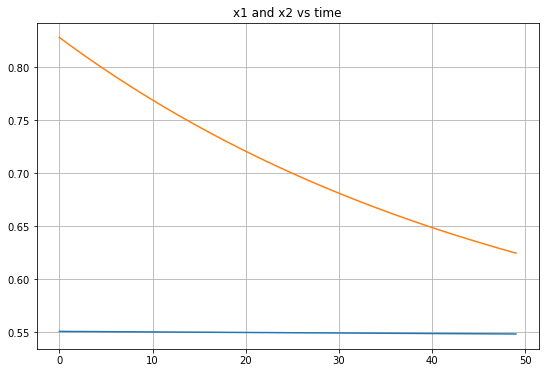

In [6]:
x_train = train_data[0:50,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

## Define the model

In [7]:
class Linear(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(Linear, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Dense Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Dense Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [8]:
class Decoder(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(Decoder, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Dense Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2):
        #print("Dense Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b

In [9]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_tilde: tensor
        return the forward time shifted Z
    """

    def __init__(self, trajLength, numTraj):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj = numTraj

    def timeShift(self,Z):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data
            m: numpy element
                Batch size
        '''

        # ******** DO EVERYTHING IN TF OR TF SLICES ****************
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength])
            z1.append(Z[i*self.trajLength,:])

        # ********** GET INPUT SIZE ROBUSTLY ********************
        return tf.reshape(Z1, [-1, 64]), tf.reshape(Z2, [-1,64]), tf.reshape(z1, [-1,64])       

    def call(self, Z):
        Z1, Z2, z1 = self.timeShift(Z)
        # Find K
        K = tf.matmul(tf.transpose(Z2),tf.linalg.pinv(tf.transpose(Z1)))

        # Find Z2_tilde
        Z2_tilde = tf.zeros([500, 64], dtype=tf.float32)
        for traj in range(self.numTraj): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 #indices = tf.constant([[traj*self.trajLength]])
                 indices = tf.constant([[1]])
                 if m == 0: 
                     updates = [tf.linalg.matvec(K, z1[0,:])]
                     tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    Ki = K
                    Ki = tf.matmul(Ki,K)
                    updates = [tf.linalg.matvec(Ki, z1[traj,:])]
                    tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                    
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(Z2-Z2_tilde))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))

        return Z, Z2_tilde

In [10]:
class Autoencoder(keras.layers.Layer):
    """
    Custom class to implement a custom autoencoder
    
    Parameters
    ----------
    x: tensor 
        inputs are the(x) data points from the dataset
        input dimension is (size of dataset,1)

    Return
    ----------
    x_hat: tensor
        the predictions (x_hat = f(x)) 

    x2_hat
        return the forward time shifted x_hat
    """


    def __init__(self):
        super(Autoencoder, self).__init__()
        #self.trajLength = tf.constant(51)
        self.trajLength = int(51)
        self.numtraj = int(510/51)
        self.encoder_1 = Linear(16)
        self.encoder_2 = Linear(32)
        self.encoder_3 = Linear(64)
        self.koopman = KoopmanLayer(self.trajLength, self.numtraj)
        self.decoder_1 = Decoder(32)
        self.decoder_2 = Decoder(16)
        self.outputLayer = Decoder(2)
      

    def call(self, x):
        # input layer
        #x = x[:, :, tf.newaxis] #fixes dimension issues with input

        # encoding layers (linear layer)
        x = self.encoder_1(x)
        x = tf.nn.elu(x)
        x = self.encoder_2(x)
        x = tf.nn.elu(x)
        x = self.encoder_3(x)
        z = tf.nn.elu(x)

        # koopman layer
        z, z2_tilde  = self.koopman(z)

        # decoding layers for x
        z, z2_tilde = self.decoder_1(z, z2_tilde)
        z = tf.nn.elu(z)
        z2_tilde = tf.nn.elu(z2_tilde)

        z,z2_tilde = self.decoder_2(z, z2_tilde)
        z = tf.nn.elu(z)
        z2_tilde = tf.nn.elu(z2_tilde)
        
        # output layer
        x_hat, x2_hat = self.outputLayer(z, z2_tilde)
        #x_hat = tf.nn.relu(z)
    
    
        return x_hat, x2_hat

ae_obj = Autoencoder()

In [11]:
inputs = tf.keras.layers.Input(shape=(2,))
output_1, output_2 = ae_obj(inputs)
ae = tf.keras.models.Model(
   inputs=inputs, outputs=[output_1, output_2])

In [12]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
autoencoder (Autoencoder)    ((None, 2), (500, 2))     5346      
Total params: 5,346
Trainable params: 5,346
Non-trainable params: 0
_________________________________________________________________


In [13]:
x_train = train_data[0:510,:]
print("Input",tf.shape(x_train))
x_hat, x2_hat = ae(x_train)
print("output Layer x_hat",tf.shape(x_hat))
print("input for predictions",tf.shape(x_train[1:,:]))

Input tf.Tensor([510   2], shape=(2,), dtype=int32)
output Layer x_hat tf.Tensor([510   2], shape=(2,), dtype=int32)
input for predictions tf.Tensor([509   2], shape=(2,), dtype=int32)


### Define a training loop

In [14]:
num_batches = 2
batch_size = 510
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[0:batch_size*num_batches,:], train_data[0:batch_size*num_batches,:]))
train_dataset = train_dataset.batch(batch_size)

In [15]:
def custom_loss(y_true, y_pred):
    """Calculates the Mean Squared Error between y_pred and y_true vectors"""
    return tf.reduce_mean(tf.abs(y_true-y_pred)) #avg loss for each batch since reduce_mean is already an avg

In [16]:
variables = ae.variables
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
epochs = 2

total_loss = [] # total loss for each epoch
for epoch in range(epochs):
  total_loss_batch = [] # ttal loss for each batch 
  #reconstruction_loss_batch = []
  #prediction_loss_batch = []
  
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      batch_length =  len(x_batch_train) #num elements in each batch
      reconstruction, prediction = ae(x_batch_train)
      
      # avg loss for each batch
      recon_loss =  custom_loss(y_batch_train, reconstruction)
      # predict_loss =  custom_loss(y_batch_train[1:,:], predictions)

      # total avg loss for each batch
      total = (recon_loss + sum(ae.losses))
      total_loss_batch.append(total)

      #reconstruction_loss_batch.append(recon_loss/batch_length)
      #prediction_loss_batch.append(predict_loss/batch_length)

    grads = tape.gradient(total, variables)
    optimizer.apply_gradients(zip(grads, variables))
    
    # Log every 100 batches.
    if step % 100 == 0:
        print(
            "Training loss (for one batch) at step %d: %.4f"
            % (step, float(total))
        )
        print("Seen so far: %s samples" % ((step + 1) * batch_size))
  
  # outside batch loop
  total_loss_avg = np.sum(total_loss_batch)/num_batches
  total_loss.append(total_loss_avg)

  print(
          "Average trainig loss at epoch %d: %.4f"
          % (epoch, float(total_loss_avg))
      )
  print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 0.6783
Seen so far: 510 samples
Average trainig loss at epoch 0: 0.6203
Time taken: 0.79s

Start of epoch 1
Training loss (for one batch) at step 0: 0.6663
Seen so far: 510 samples
Average trainig loss at epoch 1: 0.6091
Time taken: 0.72s


Text(0, 0.5, 'Total Loss')

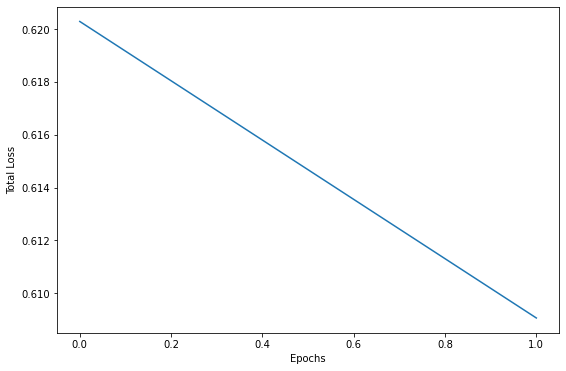

In [17]:
plt.plot(range(epochs),total_loss)
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

Visualize how the trained model performs

In [18]:
ae.save('checkpoints/test_koopman_15')

INFO:tensorflow:Assets written to: checkpoints/test_koopman_15\assets


INFO:tensorflow:Assets written to: checkpoints/test_koopman_15\assets


In [19]:
new_model = tf.keras.models.load_model('checkpoints/test_koopman_15',compile=False)

In [20]:
new_model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
autoencoder (Autoencoder)    ((None, 2), (500, 2))     5346      
Total params: 5,346
Trainable params: 5,346
Non-trainable params: 0
_________________________________________________________________


In [21]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
autoencoder (Autoencoder)    ((None, 2), (500, 2))     5346      
Total params: 5,346
Trainable params: 5,346
Non-trainable params: 0
_________________________________________________________________


In [22]:
x_hat_save, x2_hat_save = ae(x_train)
print(tf.shape(x_hat_save))

tf.Tensor([510   2], shape=(2,), dtype=int32)


In [23]:
x_hat_load, x2_hat_load = new_model(x_train)
print(tf.shape(x2_hat_load))

tf.Tensor([500   2], shape=(2,), dtype=int32)


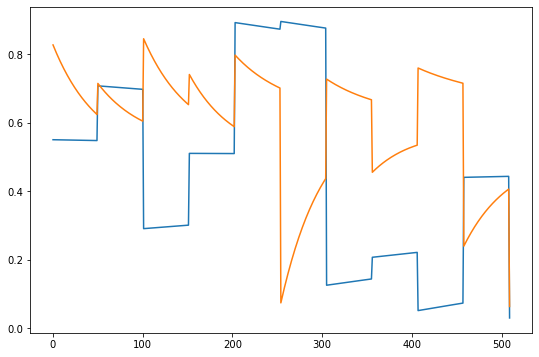

In [24]:
plt.plot(x_train)

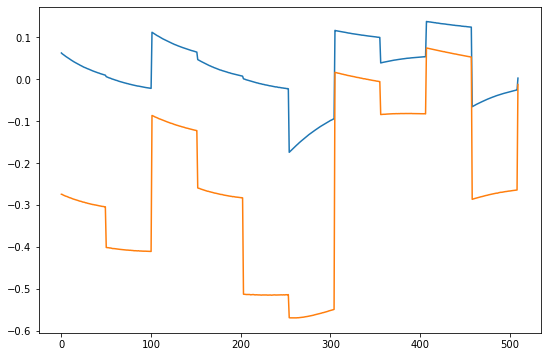

In [25]:
plt.plot(x_hat)

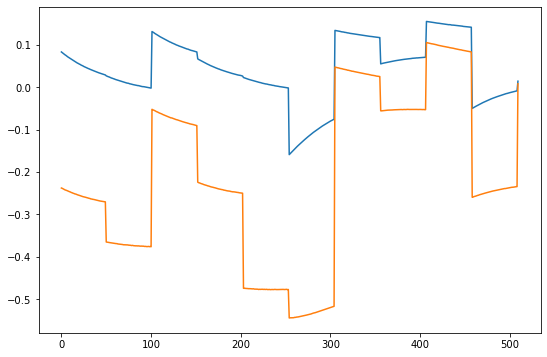

In [26]:
plt.plot(x_hat_load)